# Beta-Binomial model - Bayes' billiard - Estimating a probability

_Adapted from Josep Fortiana (2023-03-13) by Jordi Abante (2024-03-14)_

# C. Stan solution

# Model description

A plain Beta-Bernoulli model as in the Bayes' billiard problem. 

Learn about an unknown probability $\theta$ from an independent sequence of $n$ Bernoulli experiments $Y_{1},\dots,Y_{n}$ iid $\sim\operatorname{Bern}(\theta)$, in $n_{1}$ of which the $1$ value was observed.

# Observed data

$n$ Bernoulli experiments, in $n_{1}$ of which a $1$ has been observed.

In [1]:
n=10
n1=3
y <- c(rep(1,n1),rep(0,n-n1))

In [2]:
y

[1] 1 1 1 0 0 0 0 0 0 0


# Treatment with Stan and `rstan`

Stan does:

1. Generate sequences of random numbers simulating pdf's, e.g., posterior, prior or posterior predictive pdf's.

2. "Outsource" out of R execution of repetitive (i.e., slow) tasks.

3. Using flavors of Markov Chain Monte Carlo (MCMC) simulation (usually). By default Stan uses the _No-U-Turn Sampler (NUTS)_ 
   version of _Hamiltonian Monte Carlo (HMC)._

4. Stan generates a C++ source file which is compiled (out of R) to an ad-hoc executable which generates the random sequences, which are then imported back into R. 

The `rstan` R package is an interface to Stan. See the  [Stan home page](http://mc-stan.org/)).

In [3]:
#install.packages("rstan", dependencies=TRUE,repos= "https://cloud.r-project.org")
require(rstan,quietly=TRUE)


rstan version 2.32.3 (Stan version 2.26.1)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)




In [4]:
# Following directions:
# For execution on a local, multicore CPU with excess RAM we recommend calling
# options(mc.cores = parallel::detectCores()).
# To avoid recompilation of unchanged Stan programs, we recommend calling
# rstan_options(auto_write = TRUE)
parallel::detectCores()
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

[1] 8

## Specify model

#### Syntax similarities and differences between Stan and BUGS/JAGS

1. Stan requires declaration of numeric type, including specification of range limits when appropriate.

2. Statement lines in Stan end with a semicolon.
 
3. Comments in Stan are like in C++, a "//" to the end of line.
 
4. In Stan model statements are vectorized. Here the line `y~bernoulli(theta)` replaces the BUGS loop
     ```
     for ( i in 1:N){
         y[i]~dbern(theta)
         }
      ```
5. The formerly accepted Stan assignation (`<-`), as in R, has been deprecated.  Now the (`=`) symbol is mandatory.

In [5]:
modelString <- "
  data{
    int<lower=0> n ;
    int y[n] ; 
    real<lower=0> a ;
    real<lower=0> b ;
    }
  parameters{
    real<lower=0,upper=1> theta ;
    }
  model{
    theta ~ beta(a,b) ;
    y ~ bernoulli(theta) ; 
    }"

## Compile model and sample from the posterior pdf

First, we can compile model

In [6]:
# Translate model to C++ and compile to DSO:
stanDso <- stan_model( model_code=modelString ) 

We create the datalist that we will pass to the sampling function

In [7]:
# Specify data:
n <- 10 
n1 <- 3
a <- 2
b <- 5
y <- c(rep(1,n1),rep(0,n-n1))
dataList <- list(y=y,n=n,a=a,b=b)

Once datalist has been defined, we can sample values of $\theta$ from the posterior (which we know follows a beta distribution) 

In [8]:
# Generate posterior sample:
stanFit <- sampling( object=stanDso, 
                     data = dataList, 
                     chains = 3, # number of Markov chains
                     iter = 2000, # iterations for each chain (including warmup)
                     warmup = 200, #  (aka burnin) iterations per chain
                     thin = 2) # specifying the period for saving samples

We know that $\theta\mid X \sim \textrm{Beta}(\alpha+n_1,\beta+n-n_1)$:

In [9]:
post.a<- a + n1
post.b <-b + n -n1
post.a
post.b

[1] 5

[1] 12

And we also know that the expected value for a $\textrm{Beta}(\alpha,\beta)$ is given by $\alpha/(\alpha+\beta)$. Thus, the posterior expectation $\textrm{E}[\theta\mid X]$ is

In [10]:
Teor.post.mean<- post.a/ (post.a+post.b)
round(Teor.post.mean,3)

[1] 0.294

We can see that the mean of the generated samples matches this theoretical value:

In [9]:
S<-summary(stanFit)
round(S$summary,3)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
theta,0.292,0.003,0.105,0.113,0.215,0.284,0.364,0.513,1737.793,1.001
lp__,-10.795,0.015,0.691,-12.640,-10.954,-10.526,-10.349,-10.299,2007.549,0.999


## Diagnostic plots

### Traceplot

We can visualize the values obtained at each iteration of the MCMC process for each one of the chains. If the model has converged, the traceplot will move around the distribution.
A clear sign of non-convergence with a traceplot occurs when we observe some trending in the sample space.

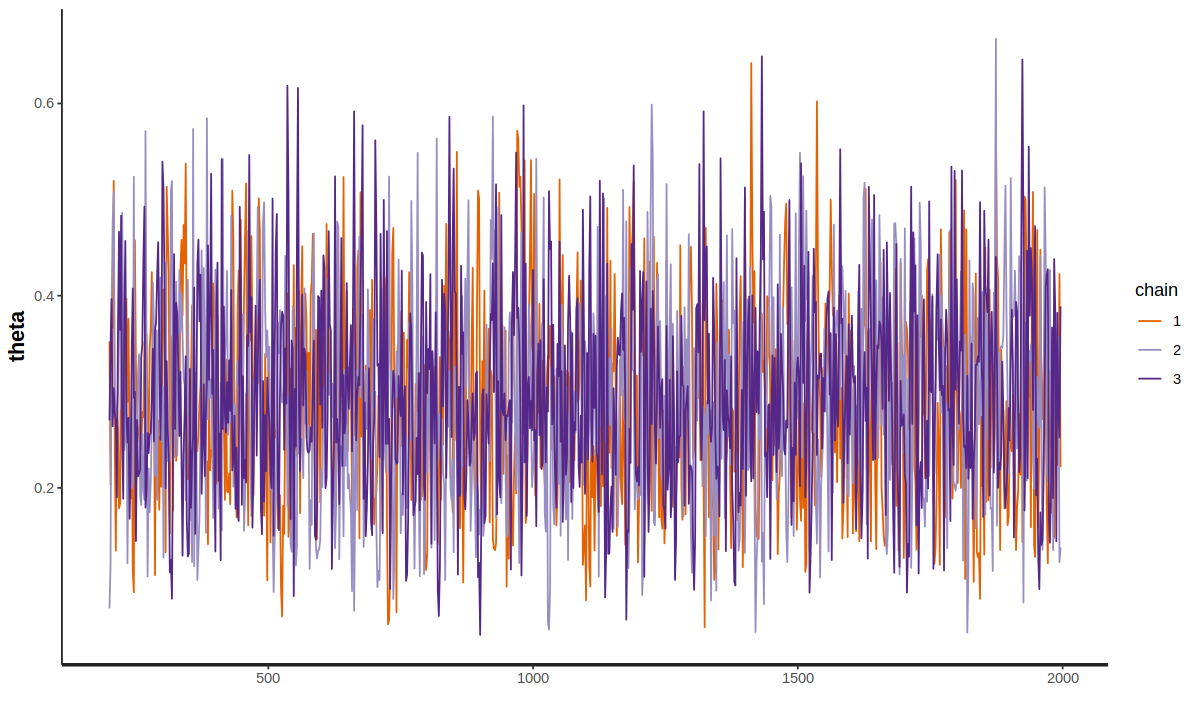

In [10]:
options(repr.plot.width=10,repr.plot.height=6)
traceplot(stanFit,pars=c("theta")) # or stan_trace(stanFit,pars=c("theta"))

Stan also has an AC plot function, but produces some errors. We will see an alternative in a little bit.

## Analysis of posterior pdf properties

### Posterior credible interval 

ci_level: 0.9 (90% intervals)

outer_level: 0.95 (95% intervals)



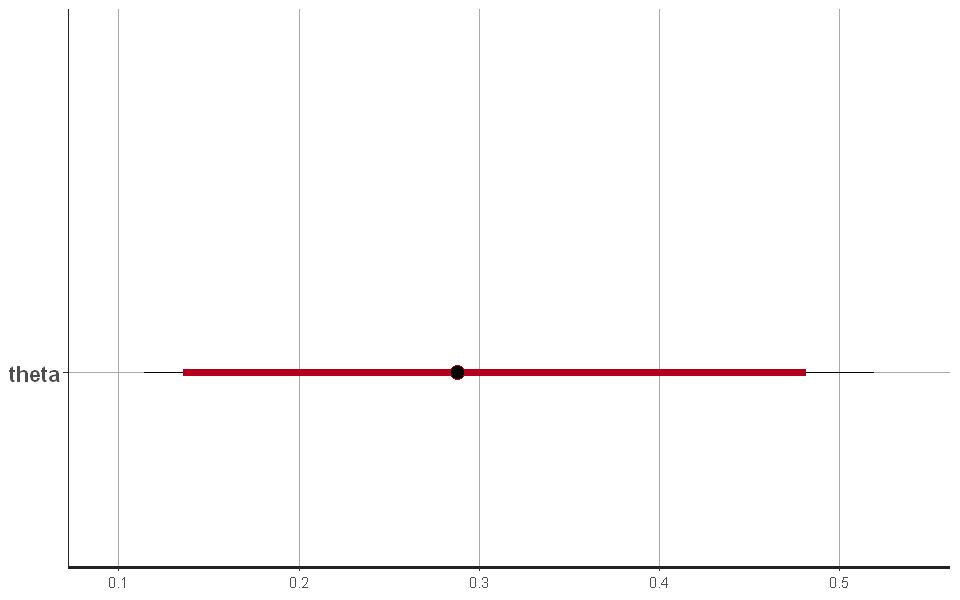

In [15]:
# Credible interval (see syntax in the stan package help)
options(repr.plot.width=8,repr.plot.height=5)
plot(stanFit,pars=c("theta"),ci_level = 0.90)

### Posterior histogram

Warning message:
"The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.
ℹ The deprecated feature was likely used in the rstan package.
  Please report the issue at <https://github.com/stan-dev/rstan/issues/>."


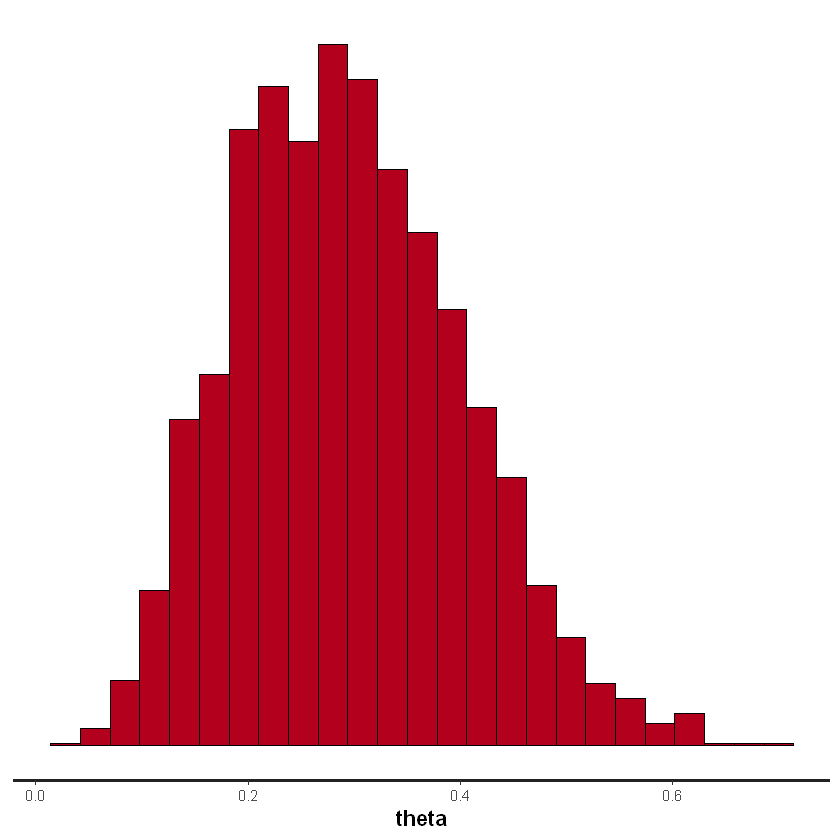

In [16]:
options(repr.plot.width=7,repr.plot.height=7)
stan_hist(stanFit,pars=c("theta"),bins=25)

### Posterior density

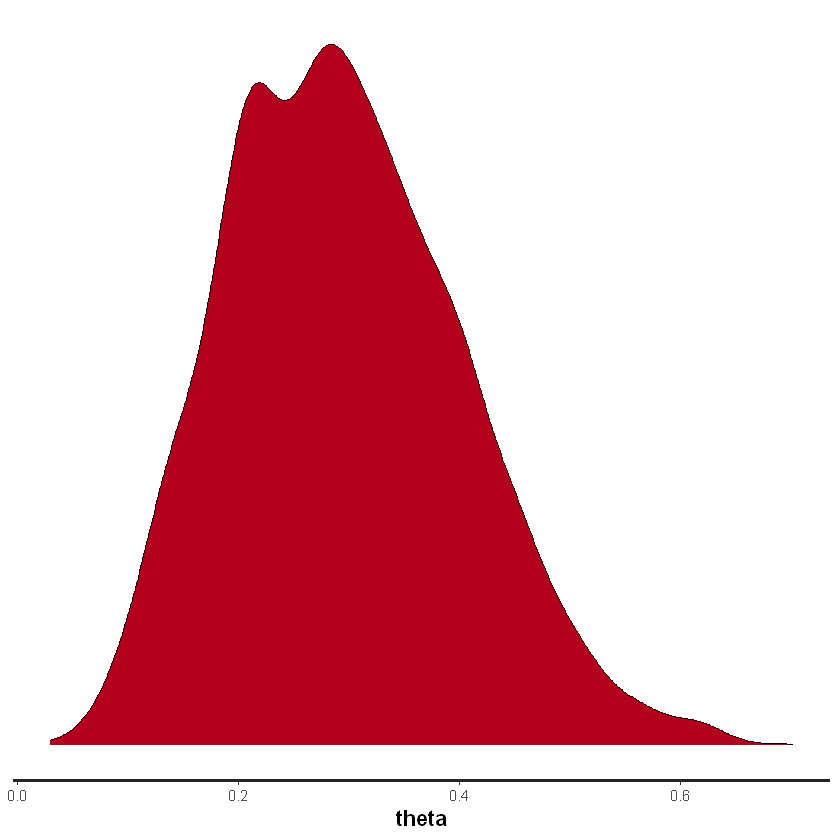

In [17]:
options(repr.plot.width=7,repr.plot.height=7)
stan_dens(stanFit,pars=c("theta"))

# Same diagrams with the `bayesplot` package

In [12]:
#install.packages("bayesplot", dependencies=TRUE,repos= "https://cloud.r-project.org")
require(bayesplot,quietly=TRUE)

This is bayesplot version 1.11.1

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting



This package allows to plot more plots.

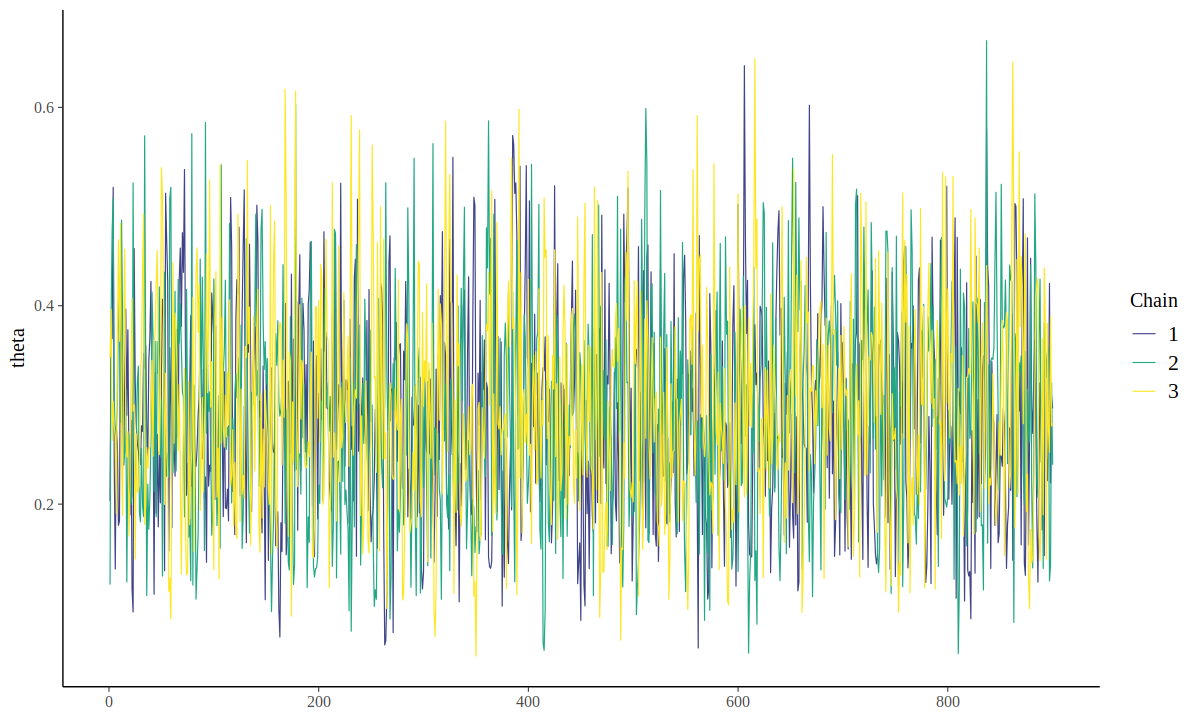

In [14]:
color_scheme_set("viridis")
options(repr.plot.width=10,repr.plot.height=6)
mcmc_trace(stanFit, pars = c("theta"))

We can highlight a specific chain too:

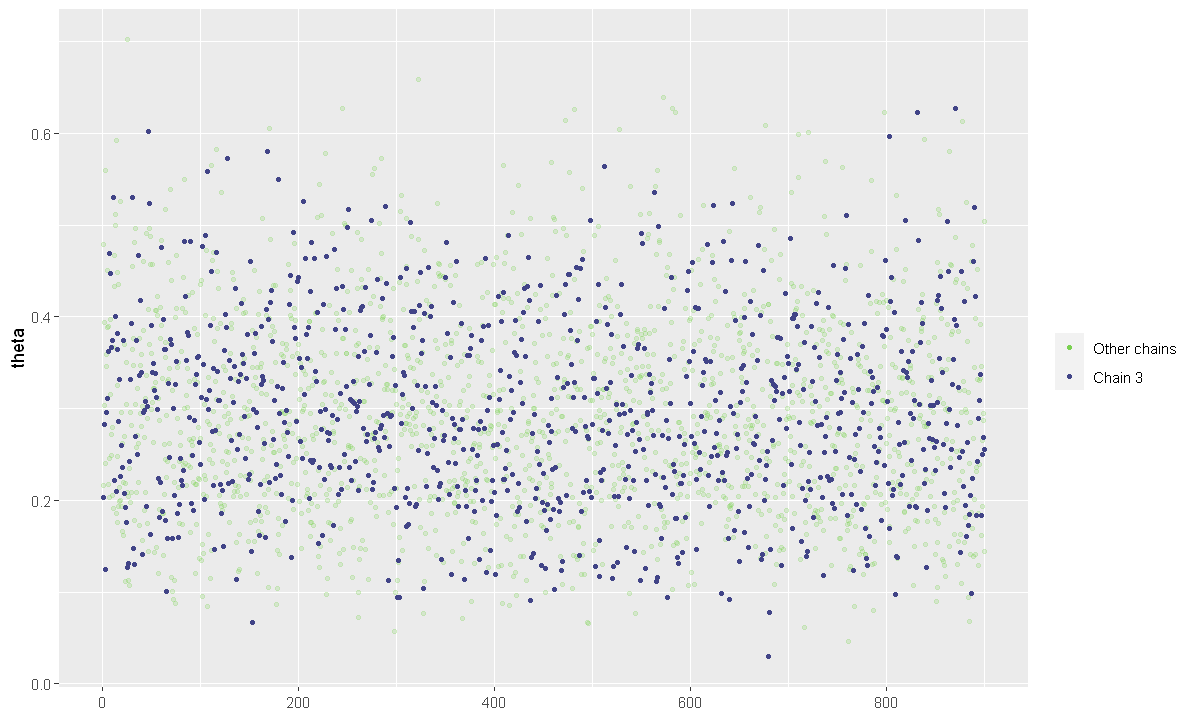

In [21]:
options(repr.plot.width=10,repr.plot.height=6)
mcmc_trace_highlight(stanFit, pars = c("theta"), highlight = 3)

Importantly, we can look at the autocorrelation function. Autocorrelation refers to the correlation between draws of the parameter (e.g., $\theta$). It can take a long time to explore the entire posterior distribution. Typically, the level of autocorrelation will decline with an increasing number of lags in the chain - as it happens in this example. However, if dampening doesn't occur, then you probably need to re-parametrize the model.

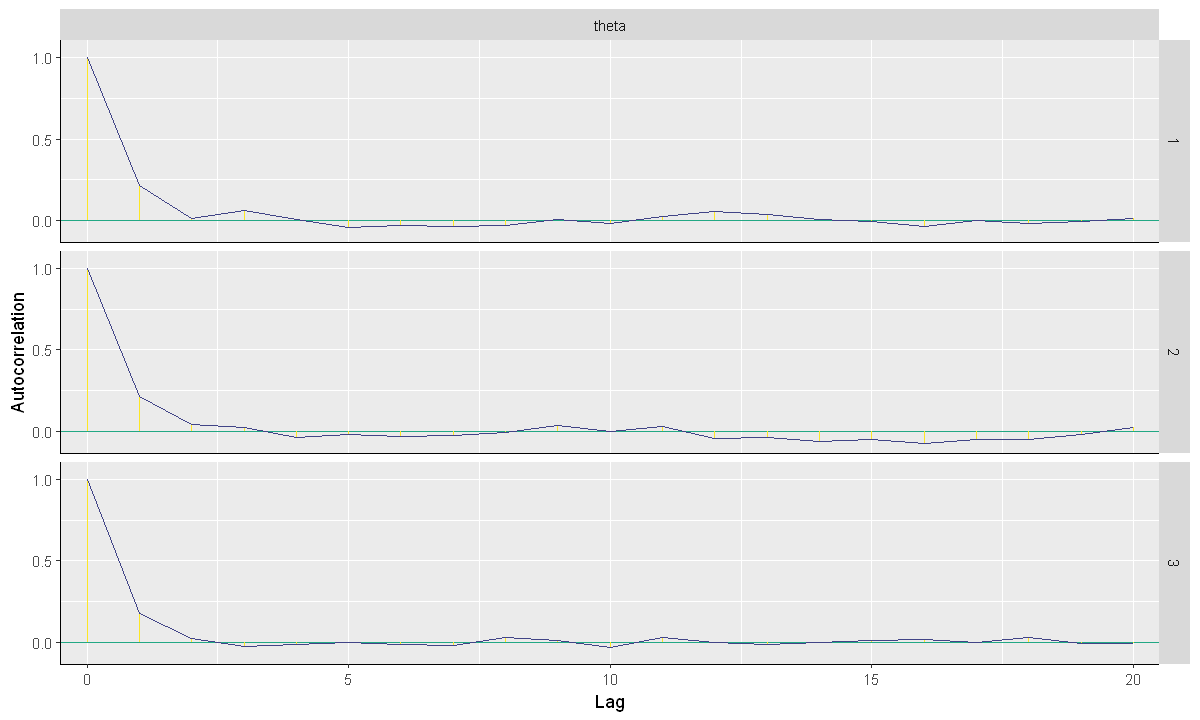

In [22]:
options(repr.plot.width=10,repr.plot.height=6)
mcmc_acf(stanFit,pars=c("theta"))

We can also visualize this using a barplot. Ideally, we want a solid bar across the screen.

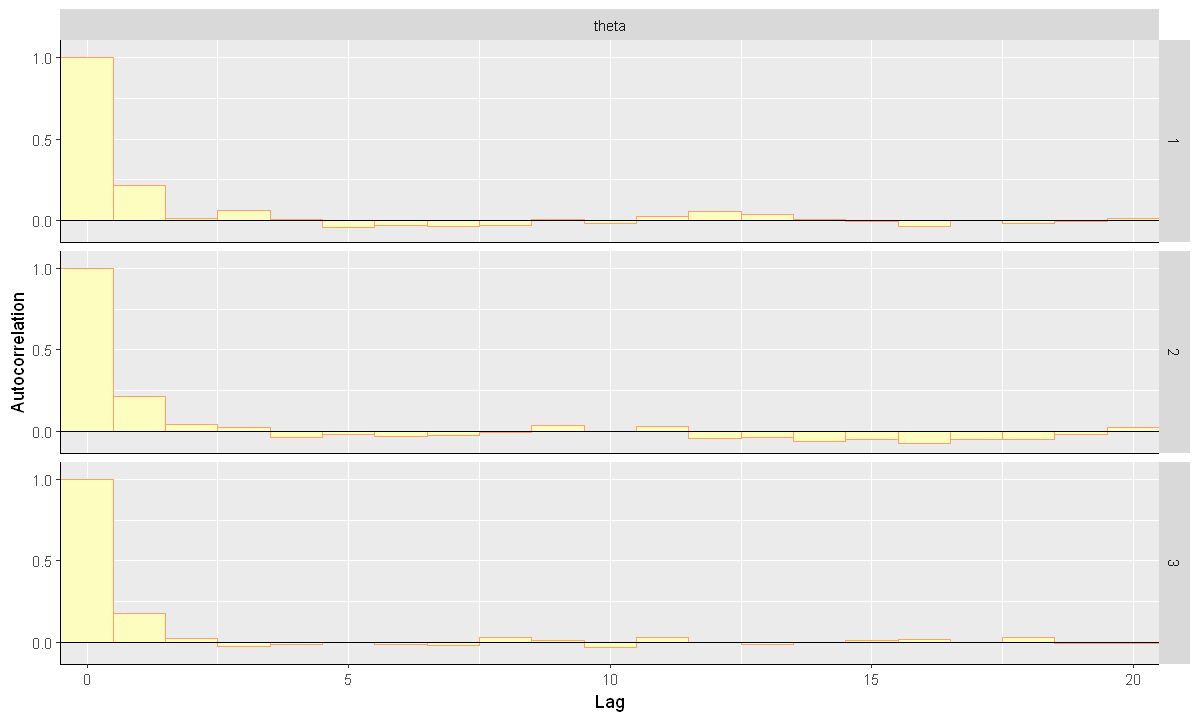

In [23]:
color_scheme_set("viridisA")
options(repr.plot.width=10,repr.plot.height=6)
mcmc_acf_bar(stanFit,pars=c("theta"))

## Analysis of posterior pdf properties

### Posterior credible interval 

Plot central (quantile-based) posterior interval estimates from MCMC draws.

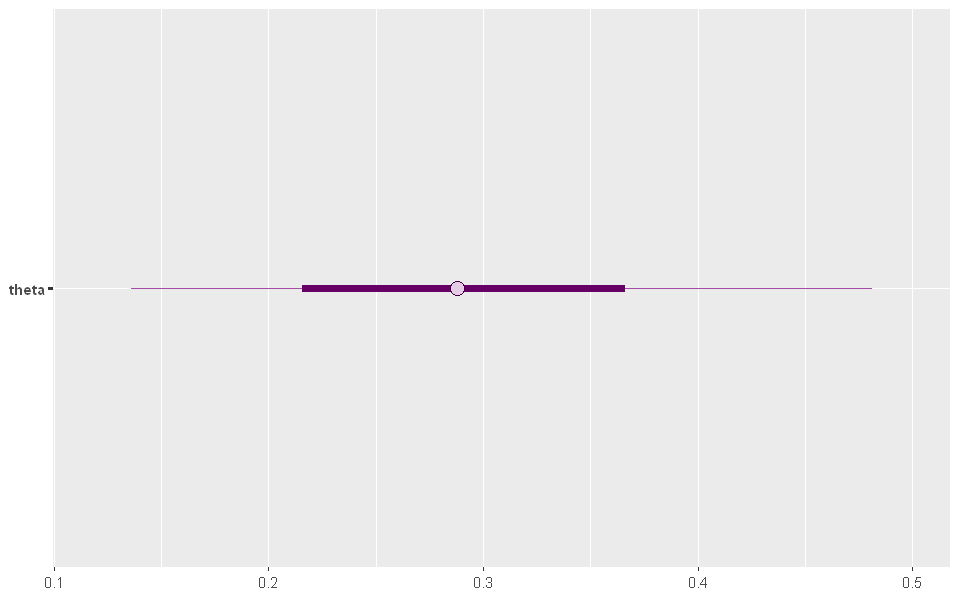

In [24]:
color_scheme_set("purple")
options(repr.plot.width=8,repr.plot.height=5)
mcmc_intervals(stanFit, pars = c("theta"))
# Defaults are
# prob = 0.5,
# prob_outer = 0.9,

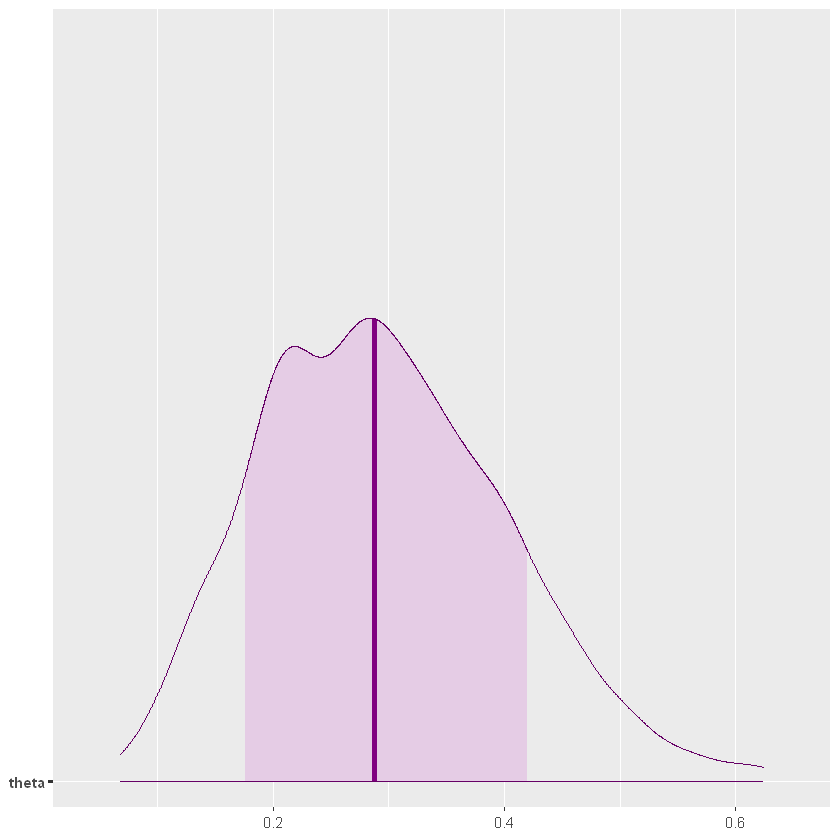

In [25]:
options(repr.plot.width=7,repr.plot.height=7)
mcmc_areas(stanFit, pars = c("theta"),prob=0.75,prob_outer=0.995)

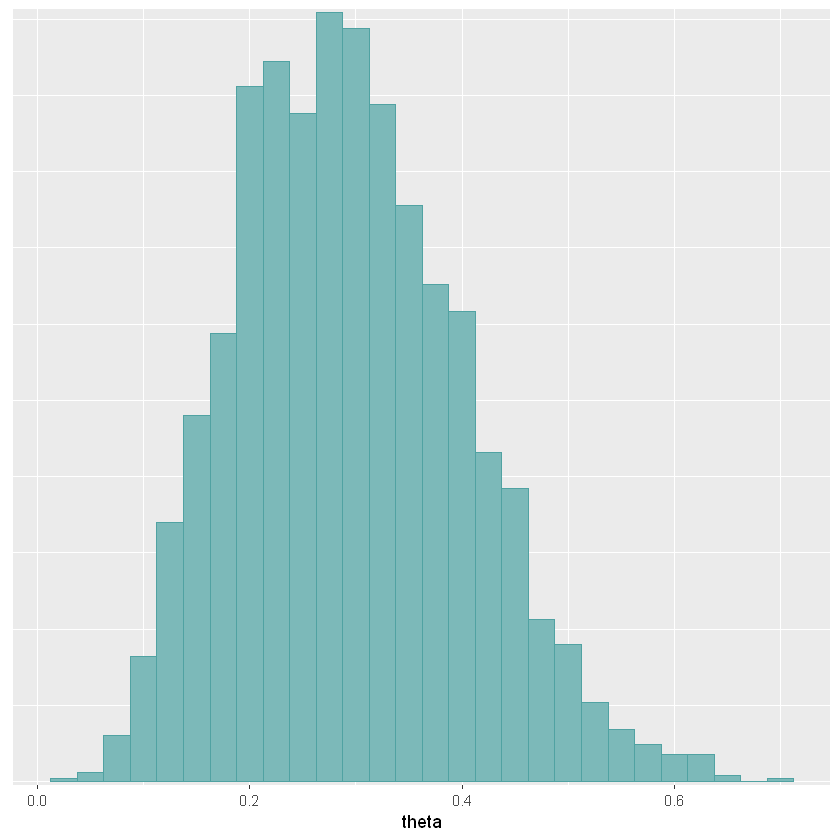

In [26]:
color_scheme_set("teal")
options(repr.plot.width=7,repr.plot.height=7)
mcmc_hist(stanFit, pars = c("theta"),binwidth=0.025)

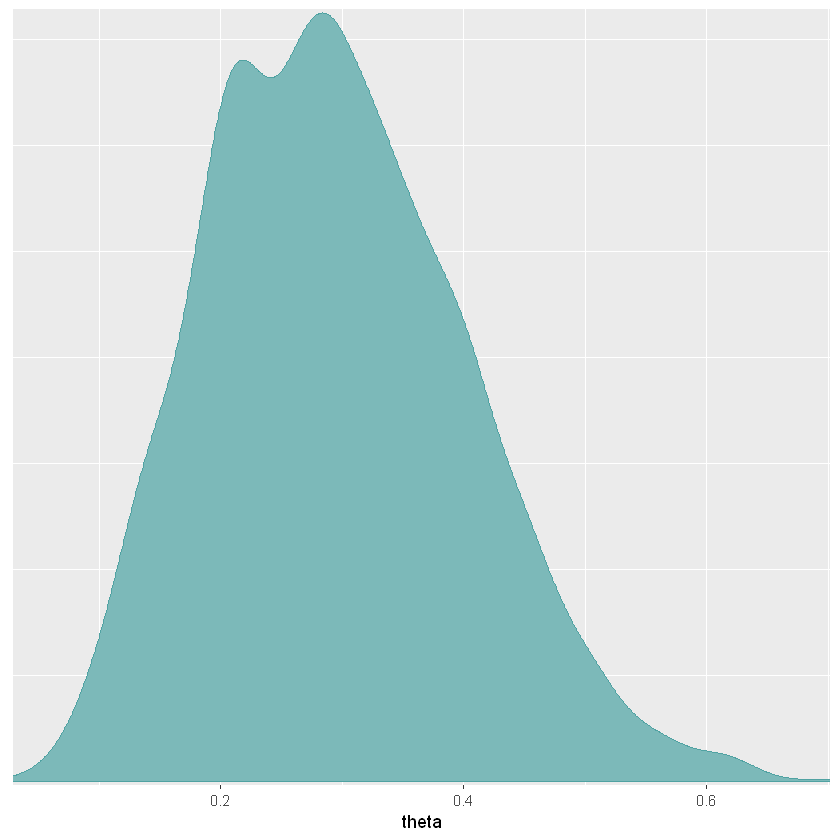

In [27]:
options(repr.plot.width=7,repr.plot.height=7)
mcmc_dens(stanFit, pars = c("theta"))

We can also look at this separately for each chain:

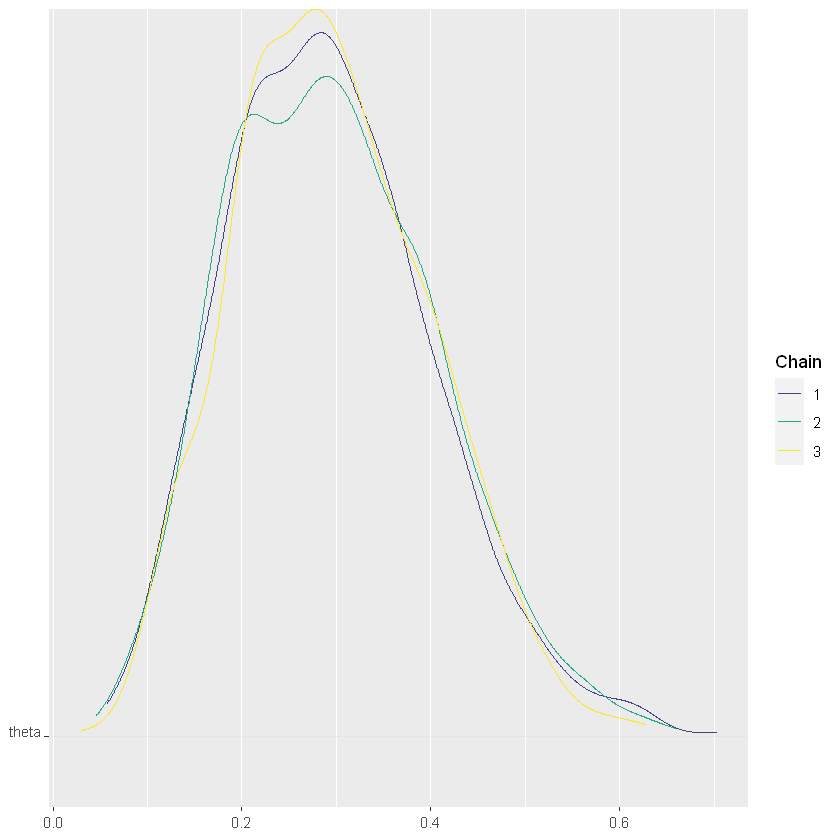

In [28]:
color_scheme_set("viridisD")
options(repr.plot.width=7,repr.plot.height=7)
mcmc_dens_chains(stanFit, pars = c("theta"))

An alternative way to visualize densities is to use violin plots, where the width indicates the proportion of draws.

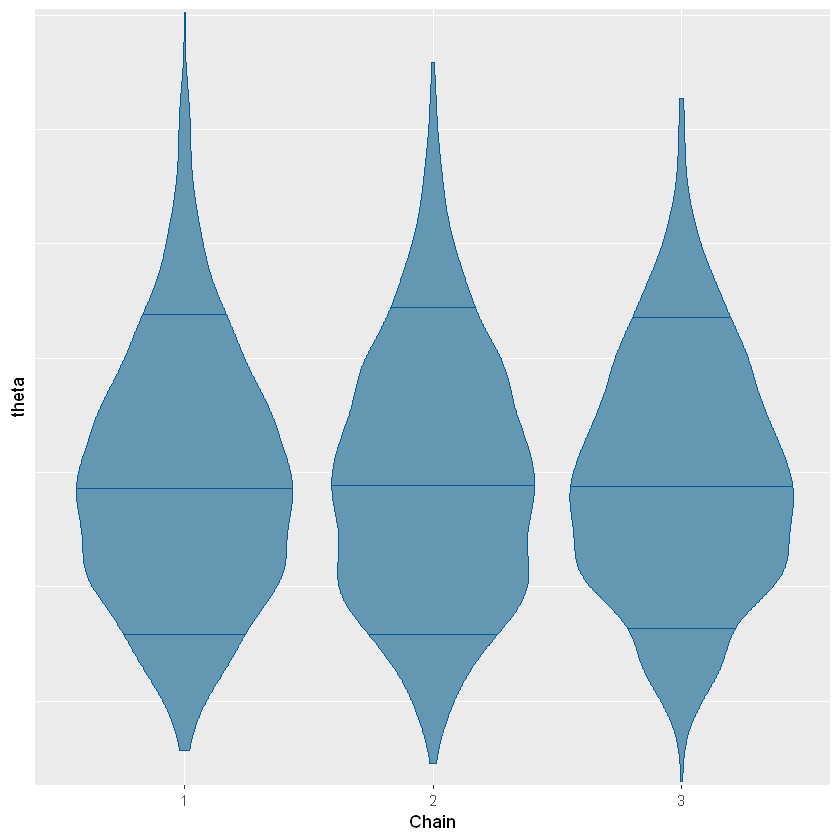

In [29]:
color_scheme_set("blue")
options(repr.plot.width=7,repr.plot.height=7)
mcmc_violin(stanFit, pars = c("theta"))

# Prior predictive simulation

In [15]:
model_PriorPred.String = "
  data{
    int<lower=0> n ;
    //int y[n] ;              //NO data needed
    real<lower=0> a ;
    real<lower=0> b ;
    }
  parameters{
    real<lower=0,upper=1> theta ;
    }
  model{
    theta ~ beta(a,b) ;
    //y ~ bernoulli(theta) ;   //NO data needed
    }
   generated quantities{
        int<lower=0,upper=n> n1_PriorPred ; 
        n1_PriorPred = binomial_rng(n,theta) ; 
    }"

## Compile model and draw samples

In [16]:
# Translate model to C++ and compile to DSO:
stanDso_PriorPred <- stan_model( model_code=model_PriorPred.String )

In [20]:
# Specify data:
n <- 10 
# n1 <- 3
a <- 2
b <- 5
dataList_PriorPred = list(n=n,a=a,b=b)

In [21]:
# Generate sample:
stanFit_PriorPred <- sampling( object=stanDso_PriorPred, 
                     data = dataList_PriorPred, 
                     chains = 3,
                     iter = 3000, 
                     warmup = 200, 
                     thin = 1)

In [22]:
prior_theta_mean<-a/(a+b)
round(prior_theta_mean,3)

[1] 0.286

In [23]:
S<-summary(stanFit_PriorPred)
round(S$summary,3)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
theta,0.284,0.003,0.161,0.041,0.157,0.265,0.387,0.642,2704.079,1.000
n1_PriorPred,2.832,0.034,2.087,0.000,1.000,3.000,4.000,7.000,3668.571,1.001
lp__,-4.748,0.014,0.787,-6.943,-4.925,-4.440,-4.244,-4.188,3105.709,1.000


In [24]:
n1_PriorPred<-as.numeric(extract(stanFit_PriorPred,pars='n1_PriorPred')$n1_PriorPred)

In [25]:
str(n1_PriorPred)

 num [1:8400] 4 4 2 3 3 3 5 3 8 1 ...


#### R language quirk:

I would like to use `table()` to obtain the absolute, then relative frequencies in this sequence. The output of `table()` omits bins with 0 frequency. Thus I will not be able to compare it with the theoretical probabilities.

In [26]:
T_PriorPred.0<-table(n1_PriorPred)
str(T_PriorPred.0)
T_PriorPred.0

 'table' int [1:11(1d)] 1113 1479 1524 1406 1133 748 482 310 143 52 ...
 - attr(*, "dimnames")=List of 1
  ..$ n1_PriorPred: chr [1:11] "0" "1" "2" "3" ...


n1_PriorPred
   0    1    2    3    4    5    6    7    8    9   10 
1113 1479 1524 1406 1133  748  482  310  143   52   10 

A better alternative is to use `tabulate()`, which lists all frequencies for each of the `nbins` I specify. Still, `tabulate()` requires **positive integers** hence I must increase by one `n1_PostPred` before calling it.

In [27]:
T_PriorPred<-tabulate(n1_PriorPred+1,nbins=n+1)
#str(T_PriorPred)
T_PriorPred

[1] 1113 1479 1524 1406 1133  748  482  310  143   52   10

In [29]:
# Table of relative frequencies (proportions)
f_PriorPred<-as.numeric(T_PriorPred/sum(T_PriorPred))
#round(f_PriorPred,3)
str(f_PriorPred)

 num [1:11] 0.133 0.176 0.181 0.167 0.135 ...


### Compare the sampled simulated prior predictive pmf and the theoretical one

From theory we known that in a model with Binomial likelihood $X\mid \theta\sim\textrm{Binomial}(n;\theta)$ and Beta prior $\theta\sim\textrm{Beta}(a,b)$, the prior predictive distribution is a Beta-Binomial (see Wikipedia).

$$
    \textrm{Beta-Binomial}(n,a,b)
$$

In [30]:
#install.packages("extraDistr",dependencies=TRUE,repos= "https://cloud.r-project.org")
require("extraDistr",quietly=TRUE)

In [31]:
# Beta-Binomial probabilities, to be compared to the above relative frequencies
x.vals<-0:n
g<-dbbinom(x.vals,size=n,alpha=a,beta=b)
#round(g,3)
#str(g)

In [32]:
# For a uniform prior both vectors approach the probabilities of a discrete uniform distribution
yfg<-cbind(f_PriorPred,g)
#round(t(yfg),3)

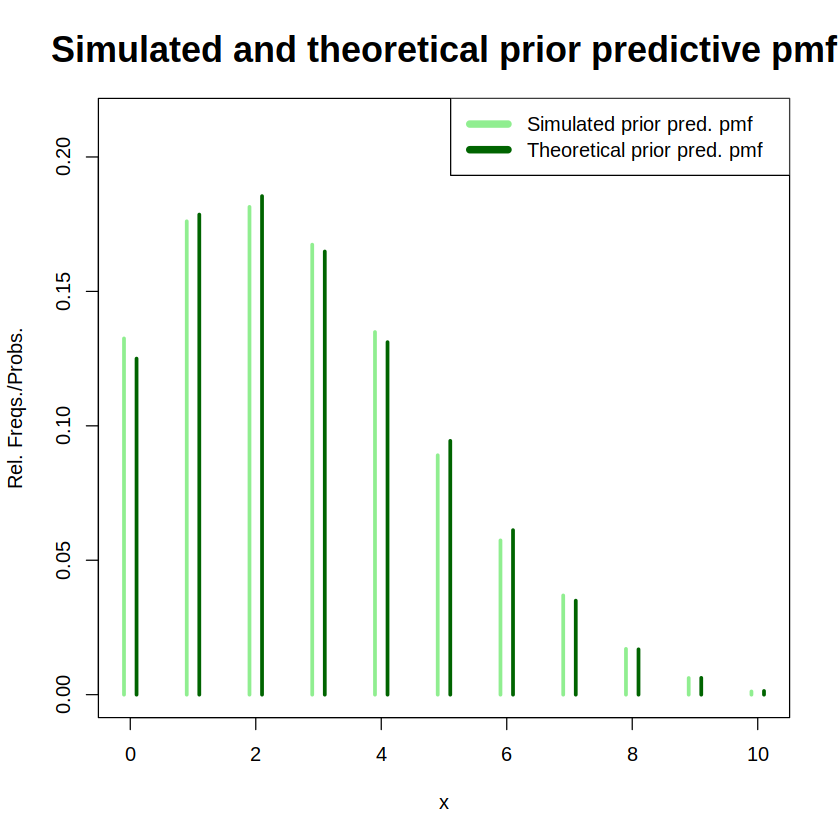

In [33]:
options(repr.plot.width=7,repr.plot.height=7)
y.max<-max(yfg)*1.15
matplot(x=cbind(x.vals-0.1,x.vals+0.1),y=yfg,type="h",lwd=3, lty=1,col=c("LightGreen","DarkGreen"),
        ylim=c(0,y.max),xlab="x",ylab="Rel. Freqs./Probs.",
        main="Simulated and theoretical prior predictive pmf",cex.main=1.8)
legend("topright",legend=c("Simulated prior pred. pmf","Theoretical prior pred. pmf"),
       lwd=6, lty=1,col=c("LightGreen","DarkGreen"))

# Posterior predictive simulation

A new experiment is performed, `New_n` trials, in which we will register the number `n1_PostPred` of ones.The posterior predictive distribution is that of `n1_PostPred`, given the previously observed `n1` successes out of `n`trials. We can enter just `n1`  instead of the full `y` vector.

In [34]:
model_PostPred.String = "
  data{
    int<lower=0> n ;
    int<lower=0,upper=n> n1 ; 
    real<lower=0> a ;
    real<lower=0> b ;
    int<lower=0> New_n ;  // New experiment to be performed
    }
  parameters{
    real<lower=0,upper=1> theta ;
    }
  model{
    theta ~ beta(a,b) ;
    n1 ~ binomial(n,theta) ;   //Now we enter y (this is critical!)
    }
   generated quantities{
        int<lower=0,upper=New_n> n1_PostPred ; 
        n1_PostPred = binomial_rng(New_n,theta) ; 
    }"

## Compile model and draw samples

In [35]:
# Translate model to C++ and compile to DSO:
stanDso_PostPred <- stan_model( model_code=model_PostPred.String ) 

In [37]:
# Specify data:
n <- 10 
n1 <- 3
a <- 2
b <- 5
New_n<-40   # We will perform New_n trials
dataList_PostPred = list(n=n,n1=n1,a=a,b=b,New_n=New_n)

In [38]:
# Generate posterior sample:
stanFit_PostPred <- sampling( object=stanDso_PostPred, 
                     data = dataList_PostPred, 
                     chains = 3,
                     iter = 10000, 
                     warmup = 200, 
                     thin = 1)

In [39]:
S<-summary(stanFit_PostPred)
round(S$summary,3)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
theta,0.295,0.001,0.109,0.11,0.214,0.285,0.366,0.529,11425.72,1
n1_PostPred,11.801,0.044,5.208,3.00,8.000,11.000,15.000,23.000,14118.60,1
lp__,-10.834,0.007,0.755,-12.94,-11.011,-10.541,-10.353,-10.299,12997.57,1


In [40]:
n1_PostPred<-as.numeric(extract(stanFit_PostPred,pars='n1_PostPred')$n1_PostPred)
str(n1_PostPred)

 num [1:29400] 5 26 11 5 12 11 15 14 10 12 ...


We can now get the frequencies

In [41]:
T_PostPred<-tabulate(n1_PostPred+1,nbins=New_n+1)

In [42]:
length(T_PostPred)
sum(T_PostPred)

[1] 41

[1] 29400

In [43]:
# Table of relative frequencies (proportions)
f_PostPred<-as.numeric(T_PostPred/sum(T_PostPred))
#round(f_PostPred,3)
str(f_PostPred)

 num [1:41] 0.000952 0.003946 0.011395 0.018946 0.031701 ...


### Compare the sampled simulated prior predictive pmf and the theoretical one

From the theory, it is known that in a model with Binomial likelihood $X\sim\textrm{Binom}(n\,|\,\theta)$, Beta prior $\theta\sim\textrm{Beta}(a,b)$, given the observed $n_{1}$ successes (or 1's, or ball on the right of the cue ball, etc.) out of $n$ trials, the posterior pdf of $\theta$, $\theta\mid n_{1}\sim\textrm{Beta}(a',b')$,  where $a'=a+n_{1}$, $b'=b+n-n_{1}$.

Now if we want to predict the output of a new batch of $n^{\text{New}}$ trials, the posterior predictive distribution
for the resulting number of successes is a Beta-Binomial:

$$
    \big(n_{1}^{\text{PostPred}}\mid n_{1}\big)\mskip10mu\sim\mskip10mu\textrm{Beta-Binom}(n^{\text{New}},a',b')
    \mskip10mu=\mskip10mu\textrm{Beta-Binom}(n^{\text{New}},a+n_{1},b+n-n_{1})
$$

In [44]:
#install.packages("extraDistr",dependencies=TRUE,repos= "https://cloud.r-project.org")
require("extraDistr")

In [45]:
# Beta-Binomial probabilities, to be compared to the above relative frequencies
x.vals<-0:New_n
g<-dbbinom(x.vals,size=New_n,alpha=a+n1,beta=b+n-n1)
#round(g,3)
#str(g)

In [46]:
# For a uniform prior both vectors approach the probabilities of a discrete uniform distribution
yfg<-cbind(f_PostPred,g)
#round(t(yfg),3)

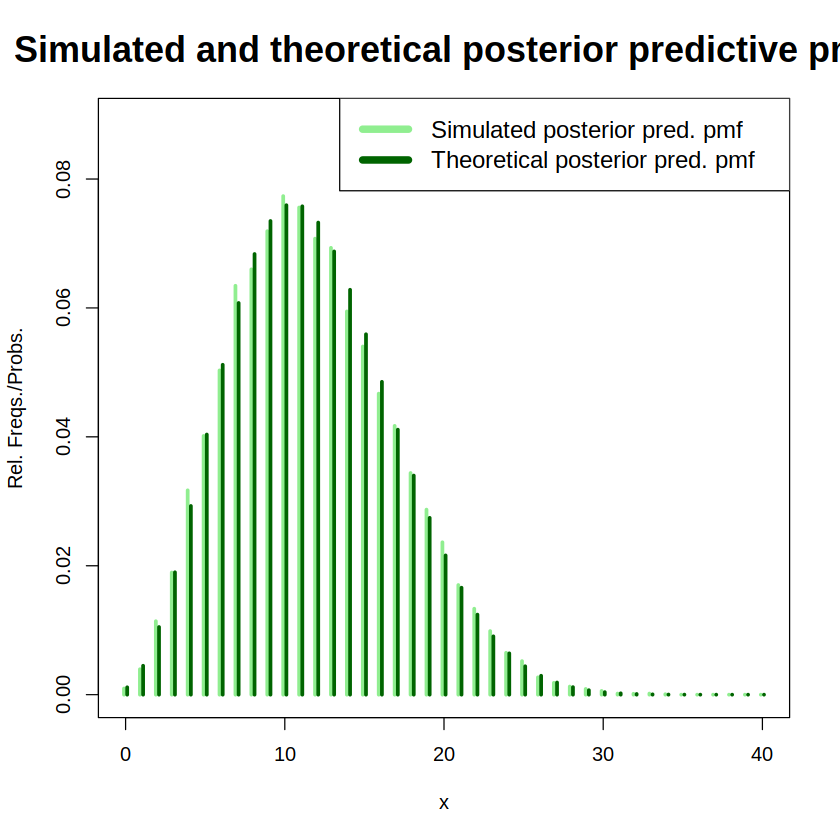

In [47]:
options(repr.plot.width=7,repr.plot.height=7)
y.max<-max(yfg)*1.15
matplot(x=cbind(x.vals-0.1,x.vals+0.1),y=yfg,type="h",lwd=3, lty=1,col=c("LightGreen","DarkGreen"),
        ylim=c(0,y.max),xlab="x",ylab="Rel. Freqs./Probs.",
        main="Simulated and theoretical posterior predictive pmf",cex.main=1.8)
legend("topright",legend=c("Simulated posterior pred. pmf","Theoretical posterior pred. pmf"),
       lwd=6, lty=1,cex=1.2,col=c("LightGreen","DarkGreen"))